In [1]:
import numpy as np
from numpy import linalg as lin
import random as rn
from pyvis.network import Network
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import triad_utils as tu

In [3]:
# UNIX
! rm net_names.txt
#v1) ! ls database >> net_names.txt
! ls matrices >> net_names.txt

In [4]:
file = open('net_names.txt')
net_names = [name.rstrip() for name in file]

In [5]:
len(net_names)

71

In [6]:
census = []
for net_num in range(len(net_names)):
    matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
    n = len(matrix)
    for i in range(n):
        matrix[i,i] = 0 # removal of self-loops
    t = tu.triad_census(matrix)
    census.append(list(t))
    
df1 = pd.DataFrame(census)
df1.columns = ['t'+str(i) for i in range(1,14)]
df1.to_csv('triads_count.csv')

In [7]:
df1.head()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,33,31,87,10,18,0,8,1,0,1,2,0,1
1,47,34,53,18,20,3,51,4,1,6,12,5,0
2,123,85,180,22,26,2,38,3,3,0,7,0,0
3,9,12,25,13,6,2,1,0,2,2,1,3,1
4,36,44,68,12,8,0,2,1,0,0,0,0,0


In [8]:
norm_df1 = df1.div(df1.sum(axis=1), axis=0) 

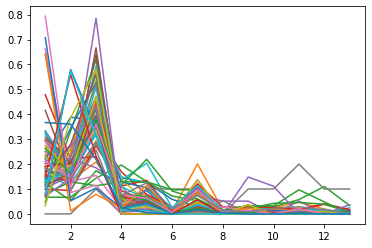

In [9]:
for i in range(len(norm_df1)):
    pr = norm_df1.loc[i]
    t = np.arange(1,14)
    plt.plot(t,pr)

In [10]:
data = [ list(norm_df1['t'+str(i+1)]) for i in range(13) ]

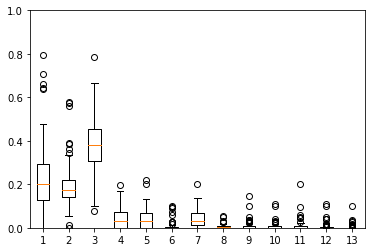

In [11]:
plt.boxplot(data,notch=False)
plt.ylim(0,1);

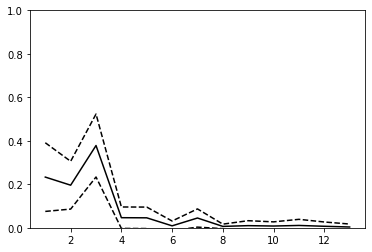

In [12]:
m = norm_df1.mean()
s = norm_df1.std()

plt.plot(t,m,'k')
plt.plot(t,m+s,'k--')
plt.plot(t,m-s,'k--')
plt.ylim(0,1);

In [13]:
df1.mean(axis=1,numeric_only=True)

0     14.769231
1     19.538462
2     37.615385
3      5.923077
4     13.153846
        ...    
66    10.923077
67    74.538462
68     2.384615
69     5.615385
70    34.384615
Length: 71, dtype: float64

# Random

In [14]:
ensemble_size = 1000

significance = []

for net_num in range(len(net_names)):
    matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
    n = len(matrix)
    n_edges = len(tu.edge_list(matrix))
    
    for i in range(n):
        matrix[i,i] = 0 # removal of self-loops
    t = tu.triad_significance_profile(matrix, ensemble_size, 100*n_edges)
    significance.append(list(t))
    
    print(net_num)
    
df2 = pd.DataFrame(significance)
df2.columns = ['t'+str(i) for i in range(1,14)]
df2.to_csv('significance_profiles.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


/Users/Enrico/Desktop/Triads-main/triad_utils.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  profile.append(  (p[i]-m[i])/s[i]  )


24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


In [17]:
#df_result = pd.DataFrame(result)
df2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,-3.061324,-2.501156,-2.354995,0.803667,1.667987,-0.480496,1.761011,-0.834248,-0.401596,1.872445,2.318512,-0.162088,31.606961
1,1.499162,0.295558,1.179789,0.343399,-0.779753,-0.239313,0.848956,-0.343687,-1.820312,-1.561965,1.033998,0.339406,-0.517086
2,-4.818484,-4.763965,-3.767173,0.909786,1.370647,2.527076,5.267814,-0.598970,3.335622,-0.603430,6.093444,-0.215318,0.000000
3,-1.431566,-2.704684,-1.708239,0.594184,-0.966883,0.438363,-1.184638,-1.211114,2.522654,1.434314,-0.418840,3.769851,6.377042
4,1.334527,0.786255,0.436898,0.787364,0.707923,-0.498566,-2.019358,-0.632017,-0.733358,-0.528003,-0.825751,-0.241838,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-3.437366,-3.942451,-2.826148,1.112762,0.841641,1.879843,2.774320,-0.782595,2.968777,-0.444080,3.812102,-0.172818,0.000000
67,-1.022960,-0.275480,-0.613558,-0.121495,0.484103,0.617764,-0.794347,-1.209919,-0.995688,0.553736,0.493233,1.116144,1.944165
68,0.722544,0.859983,1.141909,-0.778546,-0.478018,-0.089803,-0.353354,-0.568989,-0.070888,0.000000,-0.184733,0.000000,0.000000
69,0.704265,0.799994,0.324169,-0.373977,0.412333,-0.131507,-1.128984,-0.381434,-0.182144,-0.131507,-0.222271,0.000000,0.000000


In [18]:
df2.to_csv('New_run1000.csv')  

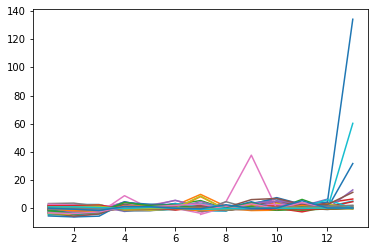

In [32]:
for i in range(len(df2)):
    pr = np.array(df2.loc[i])
    t = np.arange(1,14)
    plt.plot(t,pr)
#    plt.ylim(-1,1)

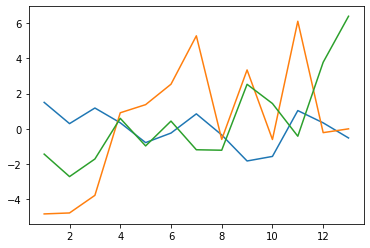

In [37]:
t = np.arange(1,14)
z1 = np.array(df2.loc[1])
z2 = np.array(df2.loc[2])
z3 = np.array(df2.loc[3])
plt.plot(t,z1)
plt.plot(t,z2)
plt.plot(t,z3)

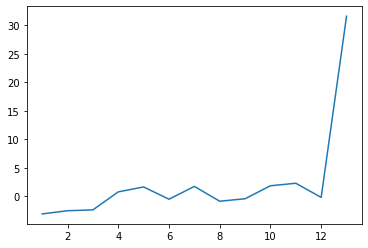

In [36]:
t = np.arange(1,14)
z0 = np.array(df2.loc[0])
plt.plot(t,z0)

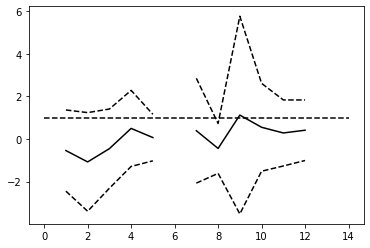

In [20]:
m = df2.mean()
s = df2.std()

plt.plot(t,m,'k')
plt.plot(t,m+s,'k--')
plt.plot(t,m-s,'k--')

plt.plot([0,14],[1,1],'--k')

# PCA of the direct census

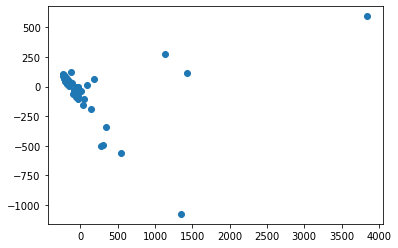

In [22]:
data0 = np.array(df1)
X_centered = df1 - df1.mean(axis = 0)
U, s , Vt = np.linalg.svd(X_centered)

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
PCA1 = X2D[0]
PCA2 = X2D[1]

plt.scatter(PCA1,PCA2);

# PCA of the normalized census

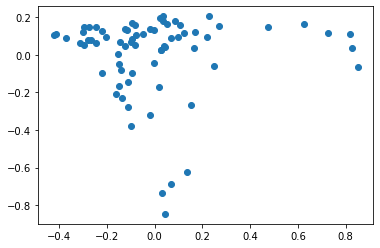

In [23]:
df1_norm = df1.div(
    np.linalg.norm(df1,axis=1),
    axis=0)

data1 = np.array(df1_norm)
X_centered = df1_norm - df1_norm.mean(axis = 0)
U, s , Vt = np.linalg.svd(X_centered)

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
PCA1 = X2D[0]
PCA2 = X2D[1]

plt.scatter(PCA1,PCA2);

# PCA of the Significance Profiles

In [42]:
# Normalization: Z -> SP
df2_norm = df2.div(
    np.linalg.norm(df2,axis=1),
    axis=0)

In [43]:
df2_norm

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,-0.095079,-0.077681,-0.073141,0.024960,0.051804,-0.014923,0.054694,-0.025910,-0.012473,0.058154,0.072008,-0.005034,0.981650
1,0.423118,0.083417,0.332979,0.096919,-0.220074,-0.067543,0.239606,-0.097001,-0.513758,-0.440843,0.291832,0.095793,-0.145940
2,-0.398818,-0.394305,-0.311802,0.075301,0.113446,0.209162,0.436008,-0.049576,0.276084,-0.049945,0.504344,-0.017822,0.000000
3,-0.159946,-0.302189,-0.190858,0.066387,-0.108028,0.048977,-0.132357,-0.135315,0.281851,0.160253,-0.046796,0.421198,0.712494
4,0.422143,0.248712,0.138201,0.249062,0.223933,-0.157708,-0.638772,-0.199922,-0.231979,-0.167020,-0.261205,-0.076499,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-0.403120,-0.462354,-0.331439,0.130500,0.098704,0.220460,0.325361,-0.091779,0.348166,-0.052080,0.447068,-0.020267,0.000000
67,-0.311403,-0.083860,-0.186775,-0.036985,0.147367,0.188056,-0.241810,-0.368315,-0.303101,0.168565,0.150147,0.339769,0.591829
68,0.366060,0.435690,0.578521,-0.394432,-0.242176,-0.045496,-0.179019,-0.288265,-0.035914,0.000000,-0.093590,0.000000,0.000000
69,0.400759,0.455233,0.184467,-0.212810,0.234636,-0.074833,-0.642443,-0.217053,-0.103648,-0.074833,-0.126482,0.000000,0.000000


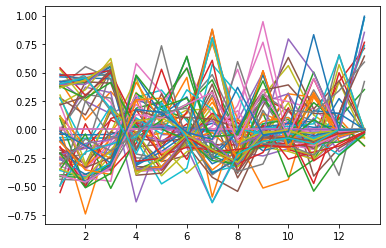

In [44]:
for i in range(len(df2_norm)):
    sp = np.array(df2_norm.loc[i])
    t = np.arange(1,14)
    plt.plot(t,sp)
#    plt.ylim(-1,1)

In [49]:
# Cleanup


data_new1 = df2_norm.copy()                                    # Create duplicate of data
data_new1.replace([np.inf, - np.inf], np.nan, inplace = True)  # Exchange inf by NaN
data_new1

data_new2 = data_new1.dropna()                                 # Delete rows with NaN
data_new2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,-0.095079,-0.077681,-0.073141,0.024960,0.051804,-0.014923,0.054694,-0.025910,-0.012473,0.058154,0.072008,-0.005034,0.981650
1,0.423118,0.083417,0.332979,0.096919,-0.220074,-0.067543,0.239606,-0.097001,-0.513758,-0.440843,0.291832,0.095793,-0.145940
2,-0.398818,-0.394305,-0.311802,0.075301,0.113446,0.209162,0.436008,-0.049576,0.276084,-0.049945,0.504344,-0.017822,0.000000
3,-0.159946,-0.302189,-0.190858,0.066387,-0.108028,0.048977,-0.132357,-0.135315,0.281851,0.160253,-0.046796,0.421198,0.712494
4,0.422143,0.248712,0.138201,0.249062,0.223933,-0.157708,-0.638772,-0.199922,-0.231979,-0.167020,-0.261205,-0.076499,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-0.403120,-0.462354,-0.331439,0.130500,0.098704,0.220460,0.325361,-0.091779,0.348166,-0.052080,0.447068,-0.020267,0.000000
67,-0.311403,-0.083860,-0.186775,-0.036985,0.147367,0.188056,-0.241810,-0.368315,-0.303101,0.168565,0.150147,0.339769,0.591829
68,0.366060,0.435690,0.578521,-0.394432,-0.242176,-0.045496,-0.179019,-0.288265,-0.035914,0.000000,-0.093590,0.000000,0.000000
69,0.400759,0.455233,0.184467,-0.212810,0.234636,-0.074833,-0.642443,-0.217053,-0.103648,-0.074833,-0.126482,0.000000,0.000000


In [46]:
len(data_new2)

69

In [277]:
# K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [286]:
X = data_new2

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 20)]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

In [287]:
silhouette_scores

[0.3340869506923258,
 0.2755399065458263,
 0.30136320229478586,
 0.3028079708027291,
 0.28771129026474335,
 0.27566879215141105,
 0.29753806681389416,
 0.2465777581336587,
 0.26870217125166435,
 0.27562545450750836,
 0.25126337004259164,
 0.2458731037159546,
 0.25623965736420135,
 0.24958547271270676,
 0.2963205493495556,
 0.298224038370787,
 0.27184432219804844,
 0.2733391781451778]

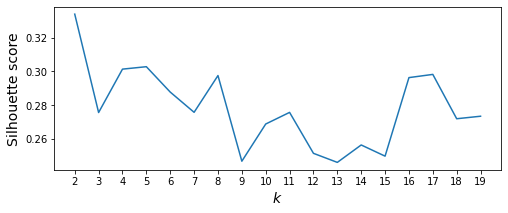

In [297]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores)
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.xticks(np.arange(2, 20, step=1))
plt.show()

In [396]:
k = 4
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(data_new2)

In [397]:
M1 = np.array([
[-0.5, -0.5060241, -0.5,0.0060241, -0.0060241,-0.0060241,0.5,0.0060241,  0.0060241, -0.0060241,
0., -0.0060241,0.],
[-0.5, -0.5, -0.5060241,0.,0.05421687,-0.01204819,0.5,-0.0060241,-0.0060241,-0.0060241,0.,0.,-0.0060241]
])



M2 = np.array([[-0.21038251, -0.33060109,  0.06830601, -0.25956284, -0.50546448,
        0.00273224,  0.13934426,  0.00273224,  0.41256831,  0.59289617,
       -0.00819672,  0.1010929 , -0.00273224],
               [-0.33060109, -0.34153005, -0.11202186, -0.34699454, -0.40710383,
       -0.23770492,  0.25409836, -0.09016393,  0.33060109,  0.43989071,
        0.03005464,  0.19398907,  0.12295082]
    
])

M3= np.array([
    [-0.0248 , -0.0248 , -0.0106 , -0.436  , -0.0745 , -0.677  ,
        0.00355,  0.0319 ,  0.457  ,  0.0603 ,  0.0532 ,  0.188  ,
        0.238  ],
    [-0.0957, -0.0816, -0.0461, -0.564 , -0.202 , -0.401 ,  0.0319,
        0.0674,  0.45  ,  0.195 ,  0.0745,  0.323 ,  0.372 ]
    
])

M4 = np.array(

[
[ 0.48   ,  0.5    ,  0.493  ,  0.147  ,  0.153  ,  0.0667 ,
       -0.353  , -0.24   , -0.12   , -0.127  , -0.147  , -0.0667 ,
        0.00667],
    [ 0.433,  0.413,  0.347,  0.273,  0.227,  0.193, -0.413, -0.18 ,
       -0.267, -0.167, -0.227, -0.16 , -0.08 ]
]
)



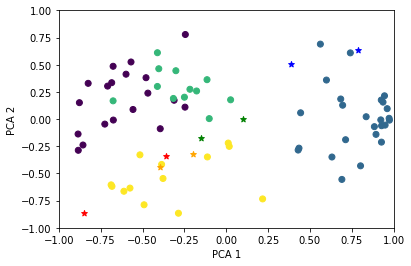

In [398]:
# PCA All data

X_centered = df2_norm - df2_norm.mean(axis = 0)
U, s , Vt = np.linalg.svd(X_centered)

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
PCA1 = X2D[0]
PCA2 = X2D[1]

plt.scatter(PCA1,PCA2, c=y_pred, label=y_pred)

# Milo family 1 (2 points, complete)

M1_centered = M1 -np.array(df2_norm.mean(axis = 0))
M1_2D = M1_centered.dot(W2)
milo_1_PCA1 = M1_2D[0]
milo_1_PCA2 = M1_2D[1]
plt.scatter(milo_1_PCA1,milo_1_PCA2, c='red',marker = '*')

# Milo family 2 (2 point)

M2_centered = M2 -np.array(df2_norm.mean(axis = 0))
M2_2D = M2_centered.dot(W2)
milo_2_PCA1 = M2_2D[0]
milo_2_PCA2 = M2_2D[1]
plt.scatter(milo_2_PCA1,milo_2_PCA2, c='orange',marker = '*')

# Milo family 3 (2 point)

M3_centered = M3 -np.array(df2_norm.mean(axis = 0))
M3_2D = M3_centered.dot(W2)
milo_3_PCA1 = M3_2D[0]
milo_3_PCA2 = M3_2D[1]
plt.scatter(milo_3_PCA1,milo_3_PCA2, c='green',marker = '*')

# Milo family 4 (2 point)

M4_centered = M4 -np.array(df2_norm.mean(axis = 0))
M4_2D = M4_centered.dot(W2)
milo_4_PCA1 = M4_2D[0]
milo_4_PCA2 = M4_2D[1]
plt.scatter(milo_4_PCA1,milo_4_PCA2, c='blue',marker = '*')


plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('PCA 1');
plt.ylabel('PCA 2');

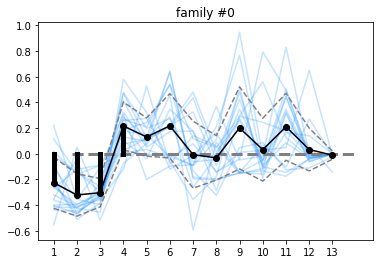

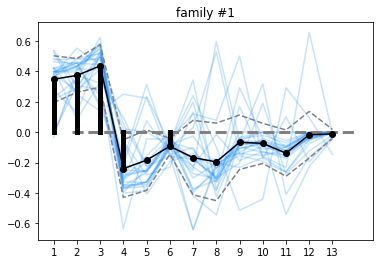

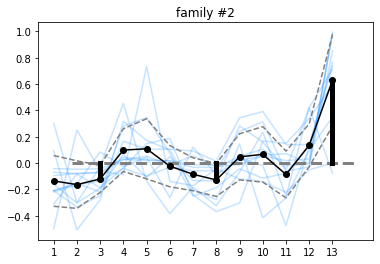

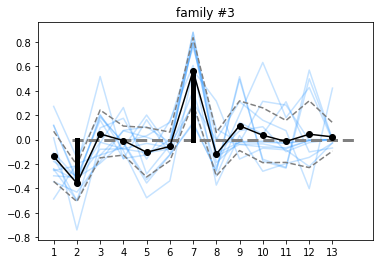

In [399]:
t = np.arange(0,13)
for y in np.unique(y_pred):
    selected_data = []
    for i in range(len(df2_norm)):
        if y_pred[i] == y:
            sp = np.array(df2_norm.iloc[i])
            selected_data.append(sp)
            plt.plot(t,sp,alpha=.25, c = 'dodgerblue')
    m = np.mean(np.array(selected_data),axis=0)
    s = np.std(np.array(selected_data),axis=0)
        
    plt.plot([0.8,13.1],[0,0],'--',c='gray',linewidth=3)
    
    plt.plot(t,m,'k')
    plt.plot(t,m,'ok')
    plt.plot(t,m+s,'--',c='gray')
    plt.plot(t,m-s,'--',c='gray')

    for k in range(13):
        if 0 <= m[k] - s[k] or 0>= m[k] + s[k]:
            plt.plot([k,k],[0,m[k]], c = 'k' ,linewidth=5)
    
    plt.xticks(np.arange(13), [str(i) for i in range(1,14)])
    
    plt.title('family #'+str(y))
    plt.show()